In [1]:
from dotenv import find_dotenv, load_dotenv
import os
load_dotenv(find_dotenv())

groq_api_key = os.environ['GROQ_API_KEY']

In [2]:
from langchain_groq import ChatGroq
llama3 = ChatGroq(api_key = groq_api_key, model = "llama-3.1-70b-versatile")
llama3

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B14FF36300>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B14FF36D50>, model_name='llama-3.1-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
llama3.invoke("Halo llama! Sebutkan 4 contoh variabel makro ekonomi!")

AIMessage(content='Halo! Berikut 4 contoh variabel makro ekonomi:\n\n1. **Pertumbuhan Ekonomi (PDB)**: Pertumbuhan ekonomi diukur dengan menggunakan Produk Domestik Bruto (PDB) yang menunjukkan nilai total barang dan jasa yang diproduksi dalam suatu negara selama satu tahun.\n\n2. **Inflasi**: Inflasi adalah kenaikan harga barang dan jasa secara umum dalam suatu negara selama satu periode waktu tertentu. Inflasi diukur dengan menggunakan indeks harga konsumen (IHK).\n\n3. **Tingkat Pengangguran**: Tingkat pengangguran adalah persentase penduduk yang tidak bekerja tetapi aktif mencari pekerjaan. Tingkat pengangguran diukur dengan menggunakan data dari survei penduduk.\n\n4. **Neraca Perdagangan**: Neraca perdagangan adalah selisih antara nilai ekspor dan impor suatu negara. Neraca perdagangan positif menunjukkan bahwa negara tersebut memiliki surplus perdagangan, sedangkan neraca perdagangan negatif menunjukkan defisit perdagangan.\n\nItulah 4 contoh variabel makro ekonomi!', additional

In [4]:
from langchain_core.tools import tool, StructuredTool
import yfinance as yf

@tool
def company_address(ticker: str) -> str:
    """
    Returns company address for input ticker.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return " ".join([info[key] for key in ['address1','city','state','zip','country']])

@tool
def fulltime_employees(ticker: str) -> int:
    """
    Returns fulltime employees count for input ticker.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return info['fullTimeEmployees']

@tool
def last_close_price(ticker: str) -> float:
    """
    Returns last close price for input ticker.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return info['previousClose']

@tool
def EBITDA(ticker: str) -> float:
    """
    Returns EBITDA for input ticker.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return info['ebitda']

@tool
def total_debt(ticker: str) -> float:
    """
    Returns total debt for input ticker.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return info['totalDebt']

@tool
def total_revenue(ticker: str) -> float:
    """
    Returns total revenue for input ticker.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return info['totalRevenue']

@tool
def debt_to_equity_ratio(ticker: str) -> float:
    """
    Returns debt to equity ratio for input ticker.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    return info['debtToEquity']

tools = [
 company_address,
 fulltime_employees,
 last_close_price,
 EBITDA,
 total_debt,
 total_revenue,
 debt_to_equity_ratio
]

In [5]:
llama3_with_tools = llama3.bind_tools(tools, tool_choice='auto')

In [6]:
ai_msg = llama3_with_tools.invoke('Hello, llama!')
print(ai_msg.content)
print(ai_msg.tool_calls)

Hello. How can I assist you today?
[]


In [7]:
ai_msg = llama3_with_tools.invoke("What's the EBITDA of Apple?")
print(ai_msg.content)
print(ai_msg.tool_calls)
EBITDA.invoke(ai_msg.tool_calls[0]['args'])


[{'name': 'EBITDA', 'args': {'ticker': 'AAPL'}, 'id': 'call_brm2', 'type': 'tool_call'}]


131781001216

In [8]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import HumanMessage, AnyMessage, SystemMessage, ToolMessage
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
class ReActAgent:
    def __init__(self, model, tools, system=""):
        self.system = system
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools, tool_choice="auto")
        graph = StateGraph(AgentState)
        graph.add_node("llama3", self.call_llm)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llama3",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llama3")
        graph.set_entry_point("llama3")
        self.graph = graph.compile()

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    
    def call_llm(self, state: AgentState): 
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling Tool : {t}")
            if not t['name'] in self.tools:
                print(f"\n Tool : {t} does not exist.")
                result = "Incorrect Tool Name, Please retry and select tool from available tools."
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id = t['id'], name = t['name'], content = str(result)))
        print("Tool execution is completed. Back to the model!")
        return {'messages' : results}


In [9]:
prompt = """
You are a smart AI finance assistant. Use the list of available tools to answer questions if needed.
You are allowed to make multiple calls (either together or in sequence).
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
agent = ReActAgent(llama3, tools, system=prompt)


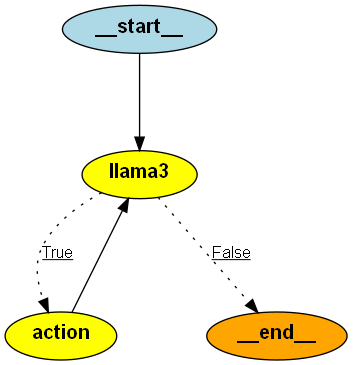

In [10]:
# Visualizing the graph
from IPython.display import Image
Image(agent.graph.get_graph().draw_png())

In [11]:
messages = [HumanMessage(content="Hi Llama 3.1?")]
result = agent.graph.invoke({'messages': messages})
result['messages'][-1].content

"Hello. I'm here to help with any questions or information you need, specifically about companies and their financial data. What would you like to know?"

In [ ]:
Hi